In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
from glob import glob
import re
import seaborn as sns

In [38]:
baseline_category = 'Baseline_left' #Do I compare migrants to themselves or non-migrants?

adjust = True
 #Adjust p-values
odds_ratio_matrix = []
p_val_matrix = []
mask_matrix = []

compared_categories = ['racist', 'sexist', 'alt_right', 'fat_shaming', 'general_hate', 'trolling_harassment', 'anti_lgbt']

for subreddit_type in compared_categories:
    file = f'./fisher_tables/all_categories/{subreddit_type}_fisher_table.csv'
 # Load in the data which contains counts for hate words of each category, for each user sample    
    home_category = re.split('/|_fisher', file)[-2]
        
    if home_category in compared_categories:
        df = pd.read_csv(file)
        df = df[df['Type'].isnull() == False]

        types = df['Type'].to_list()
        
        baseline_row = df.loc[df['Type'] == baseline_category, df.columns != 'Type'].squeeze(axis=0).to_dict()

        
        odds_ratio_row = []
        p_val_row = []
        mask_row = []
        
        for category in compared_categories:
            comparison_category = 'Left_' + category
            if comparison_category in types:
                left_row = df.loc[df['Type'] == comparison_category, df.columns != 'Type'].squeeze(axis=0).to_dict()
                
                baseline_target = 0
                baseline_other = 0

                left_target = 0
                left_other = 0
                
                comparison_words = pd.read_csv(f'./lexicons/{category}_hate_words.txt', header=None)[0].to_list()
                
                for word in baseline_row:
                    if word in comparison_words:
 #Sum words of hate group category                        baseline_target += baseline_row[word]
                        left_target += left_row[word]

                    else:
 #Sum all other words                        baseline_other += baseline_row[word]
                        left_other += left_row[word]


                table = [[left_target, baseline_target], [left_other, baseline_other]] #Fisher table 
                
                #print(home_category, category, table)
                
                odds_ratio, p_val = stats.fisher_exact(table)
 #Perform Fisher's exact                
                if adjust:
                    p_val = p_val * 7 * 6 * 2
                
                odds_ratio_row.append(odds_ratio)
                p_val_row.append(p_val)
                mask_row.append(0)
                
            else:
                odds_ratio_row.append(np.nan)
                p_val_row.append(np.nan)
                mask_row.append(1)
                
        odds_ratio_matrix.append(odds_ratio_row)
        p_val_matrix.append(p_val_row)
        mask_matrix.append(mask_row)

        

In [39]:
annotation_matrix = []
for row in p_val_matrix:
    annotation_row = []
    for val in row:
        if val < 0.001:
            annotation_row.append('***')

        elif val < 0.01:
            annotation_row.append('**')

        elif val <= 0.05:
            annotation_row.append('*')
            
        elif str(val) == 'nan':
            annotation_row.append('nan')
            
        else:
            annotation_row.append('')
            
    annotation_matrix.append(annotation_row)

In [40]:
for i in range(len(odds_ratio_matrix)):
    for j in range(len(odds_ratio_matrix[i])):
        if odds_ratio_matrix[i][j] == np.inf:
            odds_ratio_matrix[i][j] = np.nan
            

Text(0.5, 1.0, 'Odds Ratios of Language Use in Original Subreddits\nFollowing Joining of Alternate Subreddits')

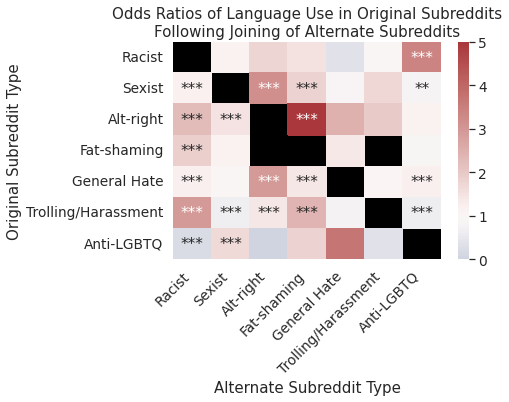

In [41]:
row_names = ['Racist', 'Sexist', 'Alt-right', 'Fat-shaming', 'General Hate', 'Trolling/Harassment', 'Anti-LGBTQ']
col_names = ['Racist', 'Sexist', 'Alt-right', 'Fat-shaming', 'General Hate', 'Trolling/Harassment', 'Anti-LGBTQ']

sns.set(font_scale=1.25)
ax = sns.heatmap(odds_ratio_matrix, vmax=5, cmap="vlag", center=1, annot=annotation_matrix, fmt='')

ax.set_yticklabels(row_names)
ax.set_xticklabels(col_names)

ax.set_facecolor('black')

ax.set_ylabel("Original Subreddit Type")
ax.set_xlabel("Alternate Subreddit Type")

plt.xticks(ha='right', rotation=45)
plt.yticks(rotation=0)

ax.set_title("Odds Ratios of Language Use in Original Subreddits\nFollowing Joining of Alternate Subreddits")

#plt.savefig('./plots/pairwise_comparisons/all_users_left_vs_stayed_vmax_5_p_adj.png', dpi=300, bbox_inches='tight')

In [35]:
odds_ratio_matrix

[[nan,
  1.3135023830009378,
  1.3221901153829534,
  1.7635863389962507,
  0.8114937552518827,
  1.0322467947816136,
  2.8286724339787455],
 [1.4864074939746086,
  nan,
  2.379308571834289,
  1.9254399814816032,
  1.0771863406345759,
  0.920600861857366,
  0.9750160957041957],
 [2.679597327257072,
  1.1201387036648984,
  nan,
  4.4707378434217855,
  1.697115418267851,
  1.2128550041160167,
  0.8524404280681555],
 [2.750471015813976,
  1.1991017713515273,
  2.8822872043211025,
  nan,
  1.7338542844175338,
  0.0,
  1.1858197358197358],
 [2.0984106876779034,
  0.8241562168523275,
  4.388897160947208,
  1.6206264250703883,
  nan,
  1.282737629120422,
  0.8693728744951384],
 [3.450922371359682,
  0.8166984779869664,
  3.146079354886371,
  2.111170167721647,
  0.6386478300573114,
  nan,
  0.4986553740076088],
 [1.1487090580726609,
  1.8179243188662153,
  0.0,
  0.8417351076407901,
  1.1138762334302525,
  1.5351606805293005,
  nan]]

## Mantel-Haenzsel Test

In [42]:
baseline_category = 'After_stayed'

adjust = True

compared_categories = ['racist', 'sexist', 'alt_right', 'fat_shaming', 'general_hate', 'trolling_harassment', 'anti_lgbt']
row_excesses = []
column_excesses = []
column_variances = []
row_p_values = []
column_p_values = []

for subreddit_type in compared_categories:
    file = f'./fisher_tables/all_categories/{subreddit_type}_fisher_table.csv'
    
    home_category = re.split('/|_fisher', file)[-2]
    
    if home_category in compared_categories:
        df = pd.read_csv(file)
        df = df[df['Type'].isnull() == False]

        types = df['Type'].to_list()
        
        baseline_row = df.loc[df['Type'] == baseline_category, df.columns != 'Type'].squeeze(axis=0).to_dict()

        total_excess = 0
        total_variance = 0
        
        for i in range(len(compared_categories)):
            if len(column_excesses) < i + 1:
                column_excesses.append(0)
                column_variances.append(0)
            comparison_category = 'Left_' + compared_categories[i]
            if comparison_category in types:
                left_row = df.loc[df['Type'] == comparison_category, df.columns != 'Type'].squeeze(axis=0).to_dict()
                
                baseline_target = 0
                baseline_other = 0

                left_target = 0
                left_other = 0
                
                comparison_words = pd.read_csv(f'./lexicons/{compared_categories[i]}_hate_words.txt', header=None)[0].to_list()
                
                for word in baseline_row:
                    if word in comparison_words:
                        baseline_target += baseline_row[word]
                        left_target += left_row[word]

                    else:
                        baseline_other += baseline_row[word]
                        left_other += left_row[word]


                table = [[left_target, baseline_target], [left_other, baseline_other]]
                total = left_target + baseline_target + left_other + baseline_other
                
                observed = left_target
                expected = (((left_target + baseline_target) * (left_target + left_other)) / total) 
                
                excess = observed - expected
                variance = ((left_target + baseline_target) * (left_target + left_other)
                            * (baseline_target + baseline_other) * (left_other + baseline_other) / (total * total * (total-1)))
                
                total_excess += excess
                column_excesses[i] += excess
                total_variance += variance
                column_variances[i] += variance
        
        z_statistic = total_excess / np.sqrt(total_variance)
        p_val = stats.norm.sf(z_statistic)
        
        if adjust:
            p_val = p_val * 7 * 4
        
        row_excesses.append(total_excess)
        row_p_values.append(p_val)
        
for i in range(len(column_excesses)):
    z_statistic = column_excesses[i] / np.sqrt(column_variances[i])
    p_val = stats.norm.sf(z_statistic)
    
    if adjust:
        p_val = p_val * 7 * 4 #2 comparisons of 2 categories (4), for each subreddit category
        
    column_p_values.append(p_val)
        

In [34]:
print(compared_categories, column_p_values)

['racist', 'sexist', 'alt_right', 'fat_shaming', 'general_hate', 'trolling_harassment', 'anti_lgbt'] [0.0, 28.0, 5.9663633371760896e-24, 2.6315913101925615e-95, 16.904518860856687, 0.00809060028065708, 1.0250215730928736]


In [43]:
pd.DataFrame(np.array([compared_categories, column_excesses, column_p_values, row_excesses, row_p_values]).T)

,0,1,2,3,4
0,racist,10119.171904233399,0.0,860.731018950791,1.1055589839971522e-99
1,sexist,-1108.7706047496301,28.0,1192.4462205863288,6.586496163882205e-109
2,alt_right,777.4784781978897,6.401835152071153e-191,2601.822027948134,7.662804366990191e-258
3,fat_shaming,1267.0893635622826,7.266603976590105e-228,164.34426712497637,5.375414472608127e-12
4,general_hate,16.4990286428254,4.278411154986608,1660.3948436434132,8.77982496048674e-49
5,trolling_harassment,20.061212541051443,4.846317189287515,3358.289443358792,6.862295018375752e-230
6,anti_lgbt,-815.8500423674925,28.0,437.65151844789017,1.50638363384044e-65


In [130]:
file = glob('./fisher_tables/categories/*')[2]

df = pd.read_csv(file)

baseline_category = 'After_stayed'

comparison_category = 'alt_right'

baseline_row = df.loc[df['Type'] == baseline_category, df.columns != 'Type'].squeeze(axis=0).to_dict()
left_row = df.loc[df['Type'] == 'Left_' + comparison_category, df.columns != 'Type'].squeeze(axis=0).to_dict()

baseline_target = 0
baseline_other = 0

left_target = 0
left_other = 0

comparison_words = pd.read_csv(f'./lexicons/{comparison_category}_hate_words.txt', header=None)[0].to_list()

for word in baseline_row:
    if word in comparison_words:
        baseline_target += baseline_row[word]
        left_target += left_row[word]
        
    else:
        baseline_other += baseline_row[word]
        left_other += left_row[word]
        

table = [[left_target, baseline_target], [left_other, baseline_other]]

print(table)

stats.fisher_exact(table)

[[0, 1], [1925, 9830]]


(0.0, 1.0)